In [73]:
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

import os, sys, shutil, math, h5py

In [38]:
survey_loc = r'J:\Projects\Surveys\HHTravel\Survey2014\Data\Final database\Release 4'
MODEL_INPUT_PATH = r'U:\angela\job_housing\soundcast_2050\job_housing_commute\final_set'

In [96]:
# model outputs
year = '2014'
scenario = 'stc'
hh_tot = 'hh_' + year
TAZ_file = 'commute_taz_' + year + '_30mins_' + scenario + '.csv'
print TAZ_file
taz_df = pd.read_csv(os.path.join(MODEL_INPUT_PATH, TAZ_file))
model_df = taz_df[['mean_dist','mean_time', hh_tot, 'count', 'job_housing_ratio', 'TAZ_P', 'county_id']]

commute_taz_2014_30mins_stc.csv


# survey 2014

In [10]:
# Load person and household records from standard survey records
person = pd.read_excel(survey_loc + r'\2014-pr3-M-hhsurvey-persons.xlsx', sheetname='Data1')
hh = pd.read_excel(survey_loc + r'\2014-pr3-M-hhsurvey-households.xlsx', sheetname='Data')
# GPS Weighted trips (in Daysim format)
trip = pd.read_csv(survey_loc + r'\Adjusted\trips_2014_adjusted_wt_daysim.csv')

In [7]:
person.columns

Index([u'chk', u'done', u'notes', u'personid', u'hhid', u'pernum',
       u'person_should_take_diary', u'person_diary_status', u'proxy',
       u'resptype',
       ...
       u'prev_work_rgc_name', u'work_parcelID_0', u'sch_parcelID_0',
       u'prevwk_parcelID_0', u'work_PIN10', u'work_PSRCPIN10', u'sch_PIN10',
       u'sch_PSRCPIN10', u'prevwk_PIN10', u'prevwk_PSRCPIN10'],
      dtype='object', length=143)

In [9]:
hh.columns

Index([u'hhid', u'traveldate', u'dayofweek', u'hhnumtrips', u'vehicle_count',
       u'hhsize', u'numadults', u'numchildren', u'numworkers', u'lifecycle',
       u'hh_income_detailed', u'hh_income_followup', u'hh_income_broad',
       u'hh_income_detailed_imp', u'hh_income_samp_est', u'sample_segname',
       u'h_address', u'h_cnty', u'h_city', u'h_zip', u'h_lat', u'h_lng',
       u'address_use_flag', u'h_segname', u'h_segname_wgt', u'h_county_name',
       u'h_taz2010', u'h_district_name', u'h_rgc_name',
       u'h_school_district_name', u'h_uv_name', u'h_uv_group', u'h_tract',
       u'h_block', u'h_bg', u'h_puma12', u'res_months', u'res_dur',
       u'rent_own', u'res_type', u'res_factors_hhchange',
       u'res_factors_afford', u'res_factors_school', u'res_factors_walk',
       u'res_factors_space', u'res_factors_closefam', u'res_factors_transit',
       u'res_factors_hwy', u'res_factors_30min', u'prev_rent_own',
       u'prev_res_type', u'prev_home_wa', u'prev_home_loc_address',
 

In [11]:
trip.columns

Index([u'hhno', u'pno', u'day', u'tour', u'half', u'tseg', u'tsvid', u'opurp',
       u'dpurp', u'oadtyp', u'dadtyp', u'opcl', u'otaz', u'dpcl', u'dtaz',
       u'mode', u'pathtype', u'dorp', u'deptm', u'arrtm', u'endacttm',
       u'trexpfac', u'id', u'travcost', u'travdist', u'travtime'],
      dtype='object')

In [12]:
# Separate college student trips from regional survey trips
college_trips = trip[trip['hhno'] < 14000000]
trip = trip[trip['hhno'] >= 14000000]

In [13]:
len(trip)

46080

In [15]:
# Home-Based Work (HBW) Trips, directly from home-to-work and work-to-home
trip['hbw'] = 0 
trip.ix[(trip['opurp'] == 0) & (trip['dpurp'] == 1), 'hbw'] = 1
trip.ix[(trip['opurp'] == 1) & (trip['dpurp'] == 0), 'hbw'] = 1

In [17]:
hbw = trip[trip['hbw']==1]

In [18]:
# Merge HH record info to HBW trip records to create cross-class tables
hbw_hh = pd.merge(hbw, hh, left_on='hhno', right_on='hhid', how='left')

# by Region

In [19]:
# total in average
weights_hbw = hbw_hh['trexpfac'].sum()
hbw_hh['travdist_fac'] = hbw_hh['travdist']*hbw_hh['trexpfac']
hbw_hh['travtime_fac'] = hbw_hh['travtime']*hbw_hh['trexpfac']
length_average = hbw_hh['travdist_fac'].sum() / weights_hbw
time_average = hbw_hh['travtime_fac'].sum() / weights_hbw

In [20]:
print length_average
print time_average

10.8541905913
24.8816881379


In [40]:
# model outputs
model_df['mean_dist'].mean()

11.17821238095094

# by TAZ

In [49]:
hbw_hh_groupby = hbw_hh[['h_taz2010', 'travdist_fac', 'travtime_fac', 'trexpfac']].groupby(['h_taz2010']).sum()
hbw_hh_groupby.reset_index(inplace=True)
hbw_hh_groupby['avg_distance_survey'] = hbw_hh_groupby['travdist_fac'] / hbw_hh_groupby['trexpfac']

In [51]:
hbw_hh_groupby.describe()

,h_taz2010,travdist_fac,travtime_fac,trexpfac,avg_distance_survey
count,1710.000000,1710.000000,1710.000000,1710.000000,1710.000000
mean,1753.794737,15181.541991,34801.525741,1398.680248,10.847521
std,1108.902259,21181.804195,41894.094188,1460.120545,8.354965
min,1.000000,-1642.827440,-1642.827440,27.567100,-1.000000
25%,696.250000,3225.631221,9781.712070,481.451467,5.068675
50%,1735.500000,8137.910541,21079.405311,928.146715,8.848657
75%,2667.750000,18726.041162,42286.254533,1753.910770,14.643750
max,3699.000000,210930.837046,396456.193213,16819.487150,61.675000


In [52]:
survey_n_model = pd.merge(left = model_df, right = hbw_hh_groupby, left_on='TAZ_P', right_on = 'h_taz2010', how = 'right')
survey_n_model['model_survey_diff'] = survey_n_model['mean_dist'] - survey_n_model['avg_distance_survey']

# Just survey viz

In [110]:
survey_df = survey_n_model

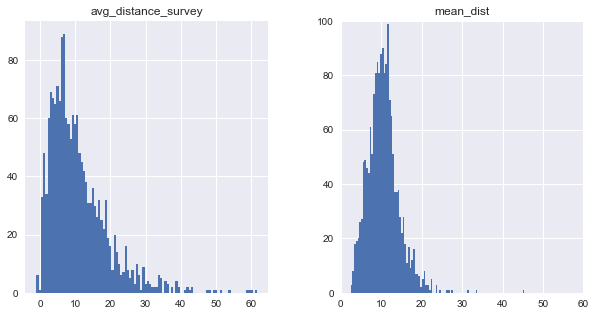

In [135]:
survey_df[['mean_dist','avg_distance_survey']].hist(bins=100, figsize=(10, 5))
plt.axis([0, 60, 0, 100])
plt.show()

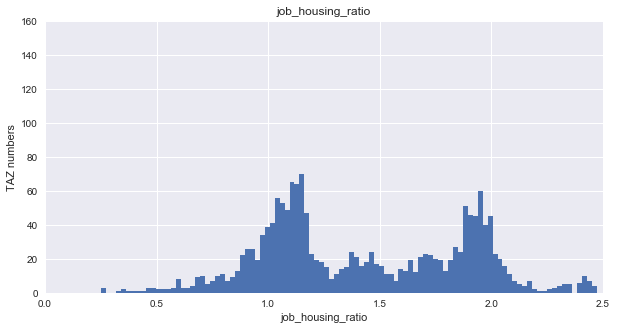

In [129]:

survey_df[['job_housing_ratio']].hist(bins=100, figsize=(10,5))
plt.axis([0,2.5, 0, 160]) 
plt.ylabel("TAZ numbers")
plt.xlabel("job_housing_ratio")
plt.show()

[0, 2.5, 0, 120000]

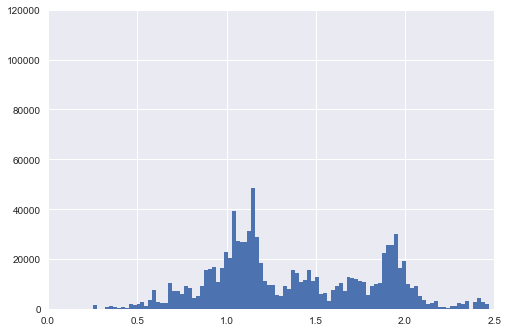

In [114]:
# household and bin 
viz_df = survey_df[['job_housing_ratio', hh_tot, 'county_id']]
viz_df = viz_df.dropna()
y = viz_df[hh_tot]
plt.hist(viz_df['job_housing_ratio'], bins=100, weights=y, histtype='bar', color=None)
plt.axis([0, 2.5, 0, 120000]) 

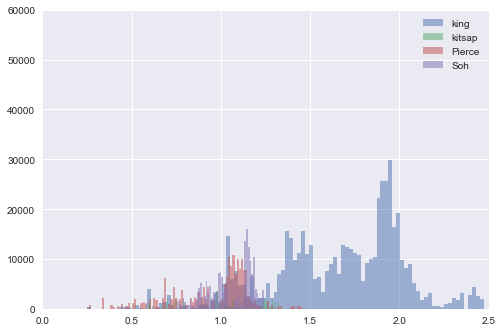

In [130]:
king_df = viz_df[viz_df['county_id'] == 33]
king_df_x = king_df['job_housing_ratio']
king_df_y = king_df[hh_tot]
kt_df = viz_df[viz_df['county_id'] == 35]
kt_df_x = kt_df['job_housing_ratio']
kt_df_y = kt_df[hh_tot]
p_df = viz_df[viz_df['county_id'] == 53]
p_df_x = p_df['job_housing_ratio']
p_df_y = p_df[hh_tot]
s_df = viz_df[viz_df['county_id'] == 61]
s_df_x = s_df['job_housing_ratio']
s_df_y = s_df[hh_tot]

from matplotlib import pyplot
pyplot.hist(king_df_x, bins=100, weights=king_df_y, histtype='bar', alpha=0.5, label='king')
pyplot.hist(kt_df_x, bins=100, weights=kt_df_y, histtype='bar', alpha=0.5, label='kitsap')
pyplot.hist(p_df_x, bins=100, weights=p_df_y, histtype='bar', alpha=0.5, label='Pierce')
pyplot.hist(s_df_x, bins=100, weights=s_df_y, histtype='bar', alpha=0.5, label='Soh')
pyplot.legend(loc='upper right')
plt.axis([0, 2.5, 0, 60000]) 
pyplot.show()

[0, 2.5, 0, 60]

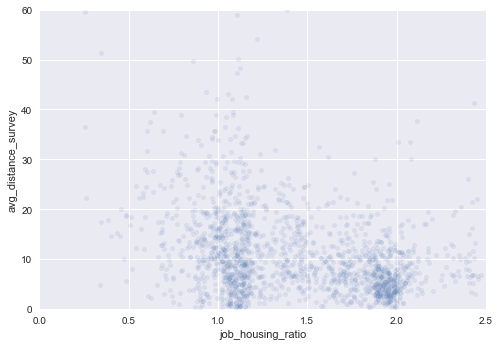

In [117]:
survey_df.plot(kind="scatter", x='job_housing_ratio', y='avg_distance_survey', alpha=0.1)
plt.axis([0,2.5, 0, 60]) 

999


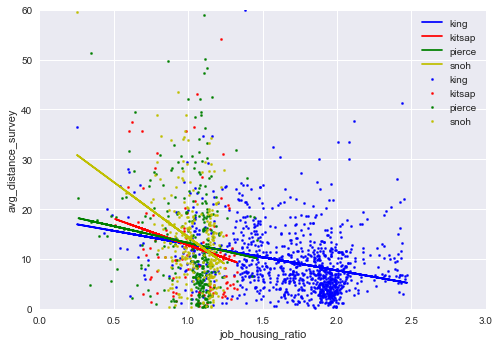

In [124]:
from numpy.polynomial.polynomial import polyfit

king_df = survey_n_model[survey_n_model['county_id'] == 33]
print len(king_df)
king_df_x = king_df['job_housing_ratio']
king_df_y = king_df['avg_distance_survey']
kt_df = survey_n_model[survey_n_model['county_id'] == 35]
kt_df_x = kt_df['job_housing_ratio']
kt_df_y = kt_df['avg_distance_survey']
p_df = survey_n_model[survey_n_model['county_id'] == 53]
p_df_x = p_df['job_housing_ratio']
p_df_y = p_df['avg_distance_survey']
s_df = survey_n_model[survey_n_model['county_id'] == 61]
s_df_x = s_df['job_housing_ratio']
s_df_y = s_df['avg_distance_survey']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(king_df_x, king_df_y, s=5, c='b', marker="o", label='king')
b, m = polyfit(king_df_x, king_df_y, 1)
plt.plot(king_df_x, b + m * king_df_x, '-', c = 'b', label = 'king')

ax1.scatter(kt_df_x,kt_df_y, s=5, c='r', marker="o", label='kitsap')
b, m = polyfit(kt_df_x, kt_df_y, 1)
plt.plot(kt_df_x, b + m * kt_df_x, '-', c = 'r', label = 'kitsap')

ax1.scatter(p_df_x, p_df_y, s=5, c='g', marker="o", label='pierce')
b, m = polyfit(p_df_x, p_df_y, 1)
plt.plot(p_df_x, b + m * p_df_x, '-', c = 'g', label = 'pierce')

ax1.scatter(s_df_x,s_df_y, s=5, c='y', marker="o", label='snoh')
b, m = polyfit(s_df_x, s_df_y, 1)
plt.plot(s_df_x, b + m * s_df_x, '-', c = 'y', label = 'snoh')

plt.ylabel("avg_distance_survey")
plt.xlabel("job_housing_ratio")
plt.legend(loc='upper right')
plt.axis([0,3.0, 0, 60]) 
plt.figure(figsize=(10,10))

plt.show()

[0, 3.0, 0, 60]

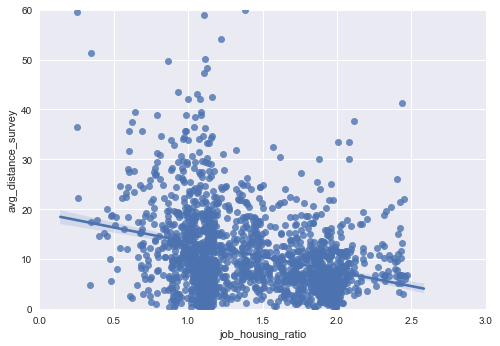

In [122]:
import seaborn 
x_reg = survey_n_model['job_housing_ratio']
y_reg = survey_n_model['avg_distance_survey']
seaborn.regplot(x_reg, y_reg)
plt.axis([0,3.0, 0, 60]) 

# compare survey to 2014 existing model

In [136]:
my_df = survey_n_model[['job_housing_ratio', hh_tot, 'model_survey_diff']]
my_df = survey_n_model.dropna()

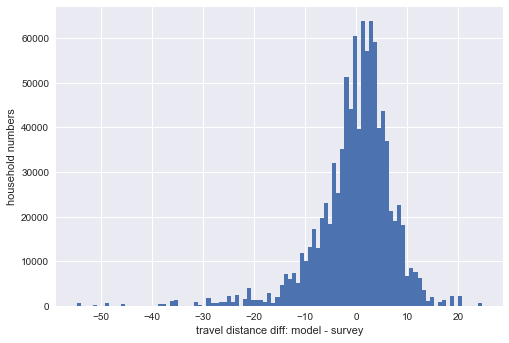

In [137]:
y = my_df[hh_tot]
plt.hist(my_df['model_survey_diff'], bins=100, weights=y, histtype='bar', color=None)
plt.ylabel("household numbers")
plt.xlabel("travel distance diff: model - survey")
#plt.axis([-50, 50, 0, 0000]) 

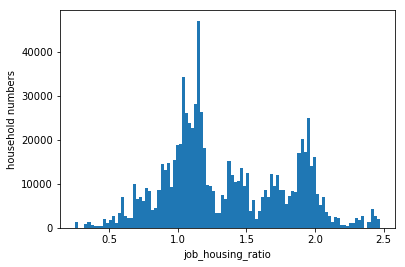

In [66]:
y = my_df[hh_tot]
plt.hist(my_df['job_housing_ratio'], bins=100, weights=y, histtype='bar', color=None)
plt.ylabel("household numbers")
plt.xlabel("job_housing_ratio")

# by county  

In [152]:
hh_hbw_groupby_county = hbw_hh[['h_county_name', 'travdist_fac', 'travtime_fac', 'trexpfac']].groupby(['h_county_name']).sum()
hh_hbw_groupby_county.reset_index(inplace=True)
hh_hbw_groupby_county['avg_distance_survey'] = hh_hbw_groupby_county['travdist_fac'] / hh_hbw_groupby_county['trexpfac']

In [153]:
hh_hbw_groupby_county

,h_county_name,travdist_fac,travtime_fac,trexpfac,avg_distance_survey
0,King,1.227542e+07,3.059486e+07,1.309807e+06,9.371930
1,Kitsap,1.626197e+06,3.437960e+06,1.291720e+05,12.589392
2,Pierce,6.197942e+06,1.334958e+07,4.964773e+05,12.483838
3,Snohomish,5.860882e+06,1.212821e+07,4.562874e+05,12.844718


In [101]:
model_df['weighted_dist_wk'] = model_df['mean_dist'] * model_df['count']
model_df_groupby = model_df.groupby(['county_id']).sum().reset_index()
model_df_groupby['averaged_dist_wk'] = model_df_groupby['weighted_dist_wk'] / model_df_groupby['count']

In [102]:
model_df_groupby

,county_id,mean_dist,mean_time,hh_2014,count,job_housing_ratio,TAZ_P,weighted_dist_wk,averaged_dist_wk
0,33.0,19209.808633,51282.015489,826267.0,1007312,3137.241157,2029565.0,1.046270e+07,10.386749
1,35.0,2076.335711,4913.491678,98701.0,105551,245.183081,831515.0,1.011274e+06,9.580905
2,53.0,8918.678446,21633.041981,302481.0,311163,699.751608,2133806.0,4.311882e+06,13.857310
3,61.0,7829.783272,19020.961832,276589.0,341476,583.903433,1353877.0,4.661064e+06,13.649756
